Principal Component Analysis (PCA) is frequently applied in machine learning as a sort of black box dimensionality reduction technique. PCA can be arrived at as an expression of a best fit probability distribution for our data. Treating PCA as a probability distribution opens up all sorts of fruitful avenues, we can draw new examples from the learned distribution and/or evaluate the likelihood of samples as we observe them to detect outliers. 

<!-- TEASER_END -->

This post is part of a series of posts about the uses of PCA such as <a href="http://asymptoticlabs.com/blog/posts/other_uses_for_PCA_part1.html"> decorrelation, semantic factor discovery, empirical noise modeling, </a> and <a href="http://asymptoticlabs.com/blog/posts/other_use_for_PCA_part2.html"> data imputation/noise reduction </a>. 
Again we will be using the same faces dataset as in the earlier posts.

## Probabilistic Interpretation of PCA

Stop to consider for a moment what you might do if I asked you to make a simple probability model for a bunch of data I handed to you as a data matrix X in tidy format with samples being rows and columns being features. The model doesn't have to be very accurate it is more important that it is easy to compute given the data and easy to handle during analysis.

Given it a moments thought? If you are like me then you might have answered something like treat each column as an independent normal distribution with width equal to its root mean square variation. That model is about as simple as you can get while still capturing something of the underlying distribution of the data. But the assumption that the different columns are independent could come back to bite us if the columns end up having lots of correlational structure. If you have read my other posts on PCA you might remember that PCA acts as a rotation which guarantees zero correlation between columns after its application. If you apply that rotation first and then model the (now guaranteed uncorrelated) columns as independent normal distributions the result is actually a very useful and fairly general probability distribution. 

The definition above of rotating our data to decorrelate our columns and then treating each column as an independent normal is actually exactly equivalent to modeling our data as being distributed like a multivariate normal distribution with a covariance matrix equal to our data covariance matrix. 

$$
p(x) \sim \mathcal{N}(x, \mu, \Sigma)
$$

Lets tie this back to the usual definition of PCA as the low rank decomposition,

$$
X = WH
$$

Where W is a n_samples by k matrix and H is a k by n_features matrix. If H is a complete basis of the column space of X then we will always be able to perfectly reconstruct X by picking the correct corresponding W coefficients. But there are some choices of basis H which have better properties than others and in PCA we choose a basis H such that the rows of H are the eigenvectors of the data covariance matrix $\Sigma = \frac{1}{N}X^TX$. By the properties of eigenvectors the basis H is orthonormal and so $H^TH = HH^T = I$. 

We said above that PCA amounts to modeling our data like a multivariate normal probability distribution with a covariance matrix equal to our data covariance matrix. Lets evaluate the data covariance matrix in terms of $W$ and $H$ and see if we can see anything interesting. For convenience I'm going to evaluate N times the data covariance matrix instead so that I can drop the factor fo $\frac{1}{N}$ from out front of my calculations.

$$
X^TX = H^TW^TWH
$$

How can we evaluate the product in the middle $W^TW$? Because of the orthonormality and completeness properties of H that we noted above putting any factor of $H^TH$ or $HH^T$ anywhere in our matrix expressions is just like putting an identity matrix into the expression, hitting our data matrix on the right with $H^TH$ we can find an expression for W in terms of H and X.

$$
X = X H^T H = WH 
$$

Therefore,

$$
W = XH^T
$$

and so,

$$
W^TW = HX^TXH^T
$$

That may not look like a simpler equation than we had but remember that we said that the rows of H were the eigenvectors of the covariance matrix $\frac{1}{N}X^TX$ that means that the product $X^TXH^T$ just gives us back the matrix $H^T$ with the eigenvalues multiplied into each column. Furthermore because of the orthonormality of H we can now see that the product $W^TW$ will be a diagonal matrix with the eigenvalues $v_i$ of $X^TX$ along the diagonal.

This alows us to rewrite the expression above in terms of a sum over the eigenvalues $v_i$ like so,

$$
X^TX = \sum_i^k v_i H_i^TH_i
$$

If we bring the factor of $\frac{1}{N}$ that we dropped at the beginning of this calculation back in then the matrix product becomes the data coviriance matrix and the eigenvalues $v_i$ become the variance $\sigma_i^2$ of the data projected along the principal vector $H_i$. Nothing else changes however and so we need only do the replacement $v_i$ -> $\sigma_i^2$ and we have found the very interesting expression of the full data covariance matrix in terms of a sum over the principal vectors,

$$
\Sigma_k = \sum_i^k \sigma_i^2 H_i^TH_i
$$

If we carry out the sum over the full number of dimensions of our input space so that k=D then there is no need for the subscript k above. The covariance matrix of our data $\Sigma$ is equal to the full sum. However we now have the option of stopping short and using just the first few principal components instead of going all the way up to the full dimensionality of the column space of X. Adding the subscript k indicates that we may have taken only a partial sum in that expansion and chosen only the first fiew directions of highest variance over which to evaluate the sum.

If D = k then the covariance matrix is equal to the full data covariance matrix and the PCA probability model is equal to the multivariate normal distribution with mean and covariance equal to our data. For a little extra intuition you can think of this as a two step process as we described above, rotate the data into a decorrelated space (that is $W$ with $H^T$ being the rotation matrix since $W = XH^T$) and then model the columns in the rotated space as independent normal distributions.

## Why?

You may be wondering why I just dragged you through all that linear algebra.
So far we haven't done anything really amazing, all we have done is rewritten the data covariance matrix into some crazy format involving eigenvectors. It is interesting to note that PCA has this connection to the multivariate normal distribution but we don't need to know about that connection in order to build a probabilistic model for our data. 

Thats fair enough and if you are dealing with a smallish number of dimensions (say tens to hundreds) and you have scads of data with which to evaluate the full covariance matrix then by all means carry on. You don't need to know about this mathematical machinery you can use the standard statistical packages to either draw samples from your multivariate normal and/or evaluate the likelihood etc. But when we are dealing with high dimensional spaces such that D is several thousand or more it becomes extremely computationally expensive to calculate or store the full covariance matrix $\Sigma$. Since the covariance matrix $\Sigma_k$ is of the same dimension storing it as a proper matrix and/or carrying out any matrix multiplications will be just as expensive as using the full matrix. However because of our nice expansion above in terms of the outer product of the eigenvectors and eigenvalues $\sigma_i^2 H_i^TH_i$ we don't have to keep around the whole matrix. By just keeping the most important few dimensions k << D we can still use this probabilistic formalism to operate in very high numbers of dimensions simply by replacing the full covariance matrix $\Sigma$ by its best k dimensional approximation $\Sigma_k$. Instead of evaluating the matrix $\Sigma_k$ explicitly anywhere it would be required we can evaluate the equivalent expression in terms of the identity above which is much more computationally friendly. As a result we can deal with probabilistic models of the form, $p(x) \sim \mathcal{N}(x, \mu, \Sigma_k)$
even when the dimension D is far too large to compute the full covariance matrix $\Sigma$. 

There is a subtlety here with respect to the normalization of the probability distribution. The normalization constant for a multivariate normal is proportional to the inverse of the determinant of the covariance matrix. If the rank k is less than the full dimension that will mean that $\sigma_k$ is singular and so has determinant 0. Thus the probability density $\mathcal{N}(x, \mu, \Sigma_k)$ is not normalizable and is technically an improper likelihood. This is an important point but one we are going to gloss over until later in this post. 

# Example Generation

Since we now have an idea of how to interpret PCA as a probability distribution lets start doing things that you can only really do with distributions. The first thing we might want to be able to do is to draw samples from our distribution. So lets fit a PCA expansion to a dataset and draw some random samples from the implied distribution. Generating examples directly from a PCA model gives useful insight into what the structure of our model is like and is often much more informative than simply looking at the principal components in isolation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import sklearn
import sklearn.datasets
import sklearn.decomposition

import scipy.stats

In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "figure.figsize":(10,6),
        "font.size":16,
        "image.cmap":"afmhot",
        "image.interpolation":"nearest",
        "image.aspect":"auto",
    }
)

Lets copy some utility functions over from the earlier posts

In [3]:
faces_ds = sklearn.datasets.fetch_olivetti_faces()

faces = faces_ds["data"]
#divide by the global standard deviation
faces /= np.std(faces)

subject_ids = faces_ds["target"]

im_shape = (64, 64)

def as_image(arr):
    return arr.reshape(im_shape)
    
def view_as_image(arr, ax=None, cmap="binary_r", **imshow_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axis("off")
    im = ax.imshow(as_image(arr), cmap=cmap, **imshow_kwargs)
    return im


So how can we sample from the normal distribution $\mathcal{N}(., \mu, \Sigma_K)$ when we can't explicitly evaluate the covariance matrix? The trick is to generate the random samples in PCA space $W$ where the variables are uncorrelated and then form the matrix product with $H$ to transform back to the full feature space. 

In [4]:
def sample_from_pca_distribution(pca, n_samples, n_dims=None):
    full_dims = len(pca.explained_variance_)
    #if no dimensionality is given assume we want to use all the dimensions
    if n_dims is None:
        n_dims = len(pca.explained_variance_)
    
    #generate uncorrelated white noise
    noise_sample = np.random.normal(size=(n_samples, full_dims))
    
    #scale the noise to have the appropriate variance in each dimension
    standard_deviations = np.zeros((n_samples, full_dims))
    standard_deviations[:, :n_dims] = np.sqrt(pca.explained_variance_[:n_dims])
    noise_sample *= standard_deviations
    
    #transform the noise back into data space
    samples = pca.inverse_transform(noise_sample)
    return samples

## Imagined Faces

Now that we have all the theory out of the way lets have some fun and draw some samples from the learned distribution over face like images!

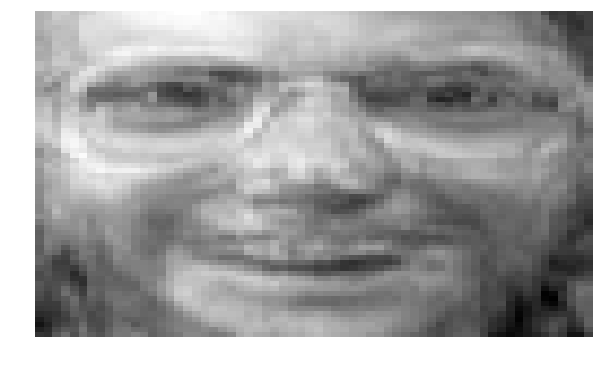

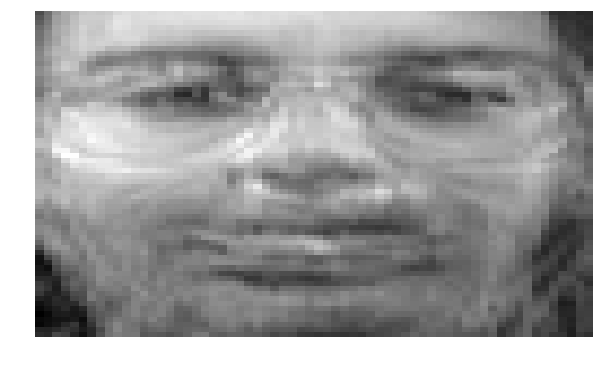

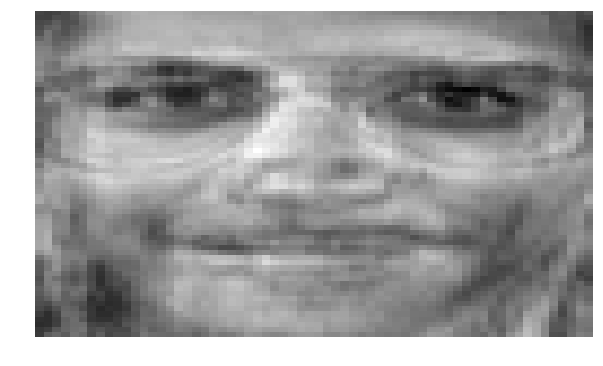

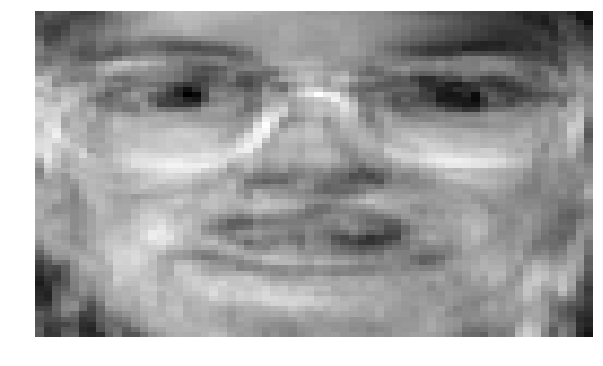

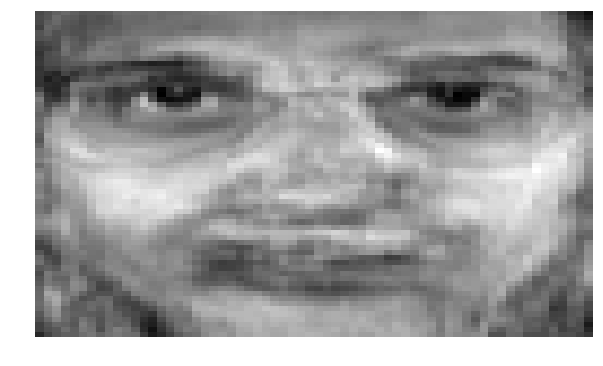

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
pca.fit(faces)

np.random.seed(1234)
imagined_faces = sample_from_pca_distribution(pca, n_samples=5)

for im_face in imagined_faces:
    view_as_image(im_face)

Sampling from this distribution is a fantastic way to interrogate our PCA model to see if it makes sense or not. If we had drawn samples which were unrecognizable as faces that would indicate that the covariance and mean of our data alone are not enough to describe it. For this data set we know that there are lots of non-linear effects within the data. For example the effect on the image of someone wearing glasses is an on/off effect you either have glasses on or you don't there is no way to linearly transition from not having glasses to having them on. Looking at the images you can see that all of the images seem to have ghostly rings around their eyes where glasses would go, none of the imagined faces seem to clearly be wearing glasses instead all of them are in some 1/2 glasses wearing limbo. 

The randomly generated faces are a little blurrier than the training images and clearly not all of the accessible parameter space correspond to realistic faces. However, the randomly generated faces are all clearly identifiable as a face and the diversity and quality of the samples is suprisingly high given the simplicity of the underlying probabilistic model. The fact that these imagined faces look pretty good is a decent indicator that treating the faces in this data set as being roughly normally distributed with covariance matrix $\Sigma_K$ is a reasonably good approximation. 

As a side note there is a strong analogy to be drawn between the "hallucinated faces" in part 2 where we (ab)used "denoising" to turn random white noise images into face like images. Those faces had much less diversity and were also much less realistic looking. Why do these images look better? In the hallucinated faces case since we generated noise images in the image space and then transformed into PCA space the variance of the $W$ coefficients were not at all well matched to the typical level of variance present in the image data. Now that we are doing things right and generating the noise in PCA space and then transforming back to an image we get better matched results.

# Statistics and Anomaly Detection

Now that we have sampling from the PCA distribution under our belts lets turn to using the PCA expansion to calculate the likelihood of samples generated in some other way and think about how we might recognize anomalous outliers.

Dealing with probability distributions on high dimensional spaces can be difficult and deciding when a point should be considered unusual or not is no exception. When we are dealing with a one dimensional probability distribution it is relatively easy to determine when a given value has a very low probability of happening and should therefore be considered "anomalous". However when we are dealing with a high dimensional probability distribution the probability density is spread out over a large high-dimensional "volume" the higher the number of dimensions the larger this effective volume and the lower the typical magnitude of the probability density is. As a result of this "typical" points in the high dimensional space have very low occurence probabilities. That is to say every point in this high dimensional space is remarkable in some sense even the most likely volumes are themselves very unlikely.

For a more down to earth analog of this surprising fact consider a well shuffled deck of cards. Every configuration has a just one in 52 factorial chance of occurring. That is a chance of just 1 in roughly $8x10^{67}$. For comparison the chance of any given lottery number winning are something like 1 in $10^7$ (specifically one in 13,983,816 for a 6-49 game where one picks 6 unique numbers ranging from 1 to 49). So every time we shuffle a deck of cards and happen to find out that just one of the 52 factorial possibilities has happened to occur is a rare event indeed, roughly the equivalent of winning the lottery 9 times in a row! An event so rare that probably no deck of cards has ever had exactly that same configuration.

So why then is no one surprised to see any given random shuffle? The answer of course is that none of these different configurations was any more or any less likely than any other and one of them had to happen. Because no particular configuration is more or less likely than any other the likelihood that we pick a configuration that is at least as rare as 1 in $10^{67}$ will occur with probability 1. Therefore a deck that happens to come out in one particular deck configuration cannot be seen as remarkable no matter how unlikely that cofiguration was in an absolute sense. 

An anomaly is an event that we should be surprised to see happen. As the example with a deck of cards shows very low absolute probability is not enough to make an event surprising. The key to detecting anomalies is to divide the space of possibilities up in to bins in such a way that the overwhelming majority of all possibilities lie in the "normal" bucket and a vanishingly small fraction $\epsilon$ lie outside. Because the probability of landing outide of the normal bucket is at most "epsilon" we can meaningfully label any points that don't meet our normal criterion as anomalies.

To return to the example of a shuffled deck of cards if we partition the set of all possible configurations into categories such that a very different number of deck configurations land in each one then a particular shuffled deck could indeed be considered anomalous. For example the configurations that result in all cards of the same suit being next to each other in the deck or perhaps more poignantly the configurations that would give you a royal flush and me a full house in a game of poker. These events could be considered "anomalous" because the overhwelming majority of all deck configurations do not result in them. But of course we must always have explicitly laid out where the boundaries between normal and anomalous lie before looking at any event, otherwise we will be back to concluding that every shuffle is miraculous in some way.

## $\chi^2$ distribution

The way that the division between normal and anomalous is usually done is to pick some statistic for which we can calculate the cumulative distribution function and to then call points "normal" if they lie below a $1-\epsilon$ threshold. A convenient statistic distribution to use is the $\chi^2$ distribution. The $\chi^2$ distribution with D degrees of freedom may be defined as the distribution of the sum of the squared magnitude of the coordinates of a point drawn from a D dimensional spherical normal distribution. 

Because PCA decorrelates the input features we can treat each column in $W$ as an independent normal distributed variable with variance $\sigma_i^2$. After dividing each column in $W$ by $\sigma$ we can treat each column as independent unit normal distributions and therefore can reason about the distribution of distances of our points from the mean using the $\chi^2$ distribution. 

Furthermore since we are treating each column in $W$ as independent of the others we can pick any combination of columns and analyze their squared sum as a $\chi^2$ distribution with a number of dimensions equal to the number of columns we picked. We will start by looking at each column individually and compare it against a $\chi^2$ distribution with 1 degree of freedom and then start looking at combinations as a $\chi^2$ distribution with k degrees of freedom.

Conveniently we can easily calculate the distribution functions for $chi^2$ using the scipy.stats package. As a helpful rule of thumb the $\chi^2$ distribution approximates a normal distribution with mean $\mu=D$ and variance $\sigma^2 = D$ with the approximation becoming better for higher numbers of dimensions D.

Text(0.5,0,'$\\chi$')

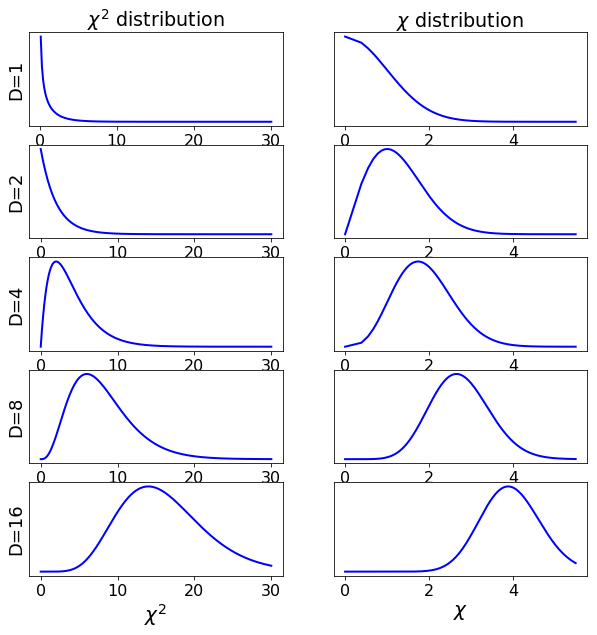

In [6]:
chi2_grid = np.linspace(0, 30, 201)
chi_grid = np.sqrt(chi2_grid)
example_dims = [1, 2, 4, 8, 16]
fig, axes = plt.subplots(len(example_dims), 2, figsize=(10, 10))

for idx, n_dims in enumerate(example_dims):
    axes[idx, 0].plot(chi2_grid, scipy.stats.chi2.pdf(chi2_grid, n_dims), c="b", lw=2)
    axes[idx, 0].set_yticks([])
    axes[idx, 0].set_ylabel("D={}".format(n_dims), fontsize=18)
    
    axes[idx, 1].plot(chi_grid, scipy.stats.chi.pdf(chi_grid, n_dims), c="b", lw=2)
    axes[idx, 1].set_yticks([])
    
axes[0, 0].set_title("$\chi^2$ distribution")
axes[0, 1].set_title("$\chi$ distribution")
axes[-1, 0].set_xlabel("$\chi^2$", fontsize=20)
axes[-1, 1].set_xlabel("$\chi$", fontsize=20)

We can easily divide the space of events into "anomalous" and "normal" categories by choosing a cut off $\chi^2$ above which we label points as anomalies. However with the exact form of the cumulative $\chi^2$ distribution at our disposal we can even go one better and ask the question "what is the chance of a randomly occuring event having a $\chi^2$ at least as high as observed?". That way we not only get just the two categories of "normal" and "anomalous" but have some indication of the strength of our conviction. If a point is an outlier at a 1 in a 1000 level that is a world of difference from being an outlier at a level of one in a trillion although potentially both could be considered outliers by some definition. 

# Anomalous Images?

That is more than enough theory without application lets try to answer the question of whether or not any of the faces in the data set are anomalous in a $\chi^2$ sense. We will begin by looking at the distribution of each column in $W$ separately then as a sum and finally we will consider how to deal with variations outside of the subspace learned by PCA.

When calculating the $\chi^2$ values we have to be careful not to use an image both for calculating the PCA expansion and evaluting the $\chi^2$ for that image. Consider the case in which we have just 2 images the normalized difference between the first and second image becomes our first (and only) principal component and the magnitude of that difference becomes our estimated RMS variance. Therefore we would always end up with a $\chi^2$ of 1 no matter what the two images looked like. To avoid these sorts of effects we need to apply some sort of cross validation technique to ensure that if we use an image to generate a PCA expansion we do not also use that PCA expansion to evaluate a $\chi^2$ value.

In [7]:
#make a cross validation split
n_folds = 10

fold_indexes = np.random.random(len(faces)).argsort() % n_folds

pca_expansions = []

max_components = 350

for fold_idx in range(n_folds):
    train_faces = faces[fold_indexes != fold_idx]
    fold_pca = PCA(n_components=max_components)
    fold_pca.fit(faces[np.arange(len(faces)) != fold_idx])
    pca_expansions.append(fold_pca)

Now that we have a set of PCA expansions trained on 90% of the data we can go back and find out how strange in a $\chi^2$ sense each image is compared to the training set that left that image out. First we project the images into PCA space and collect the variance associated with each dimension and collect the results for each fold.

In [8]:
projected_coeffs = np.zeros((len(faces), max_components))
projection_variances = np.zeros(projected_coeffs.shape)

for fold_idx in range(n_folds):
    cur_pca = pca_expansions[fold_idx]
    fold_mask = fold_indexes == fold_idx
    
    lof_transform = cur_pca.transform(faces[fold_mask])
    transformed_variances = cur_pca.explained_variance_
    
    projected_coeffs[fold_mask] = lof_transform
    projection_variances[fold_mask] = transformed_variances

The projected PCA coefficients represent how far from the mean we are along a direction in the high dimensional image space corresponding to each principal vector. Meanwhile the corresponding variances which have been fit by the PCA expansions for each direction indicate what the typical scale of variation is normal. We can transform the PCA coefficients into a $\chi^2$ term by taking the square of the coefficients (that will be the squared distance from the mean along the direction of the corresponding principal vector) and dividing that by the variance. 

In [9]:
chi2_per_dimension = projected_coeffs**2/projection_variances

## $\chi$ distributions for 1 degree of freedom

If our data distribution is really distributed like a multi variate normal then we should expect the $\chi^2$ for each dimension alone to be distributed like a theoretical $\chi^2$ distribution of one degree of freedom (abbreviated as D.o.F.). We can compare a normalized histogram of the resulting $\chi^2$ values with what we would expect based on integrating the theoretical $\chi^2$ distribution over the bins of our data. 

In [10]:
def distribution_comparison_plot(
    x,
    distribution,
    hist_kwargs=None,
    ax = None,
):
    if ax is None:
        fig, ax = plt.subplots()
    
    if hist_kwargs is None:
        hist_kwargs = {}
    
    hvals, hbins, patches = ax.hist(x, normed=True, histtype="step", lw=3, **hist_kwargs)
    
    #integrate the probability distribution over the histogram bins
    bin_integrals = np.diff(distribution.cdf(hbins))
    bin_centers = 0.5*(hbins[1:]+hbins[:-1])
    bin_dx = np.diff(hbins)
    
    ax.plot(bin_centers, bin_integrals/bin_dx, lw=3, alpha=0.7)

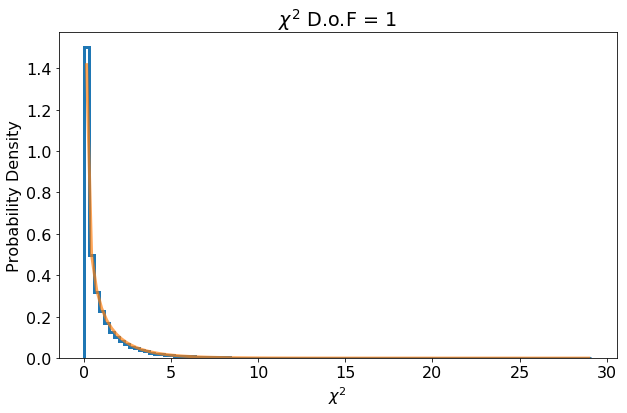

In [11]:
distribution_comparison_plot(
    chi2_per_dimension.ravel(), 
    distribution=scipy.stats.chi2(df=1), 
    hist_kwargs={"bins":101,} 
)
plt.title("$\chi^2$ D.o.F = 1")
plt.ylabel("Probability Density")
plt.xlabel("$\chi^2$");


Although it is clear that the theoretical $\chi^2$ and the observed distributions are very close the long tail of the distribution makes it difficult to compare the data over the full range of values. To squeeze the x axis down a little bit and make the plot easier to read we instead will compare the square root of the $\chi^2$ value to the theoretical $\chi$ distribution. This quantity is sometimes a little more intuitive since it corresponds to the absolute value of distance from the distribution mean divided by the standard deviation along that dimension wich can sometimes be easier to think about than squared distance divided by variance.

Text(0.5,0,'$\\chi$')

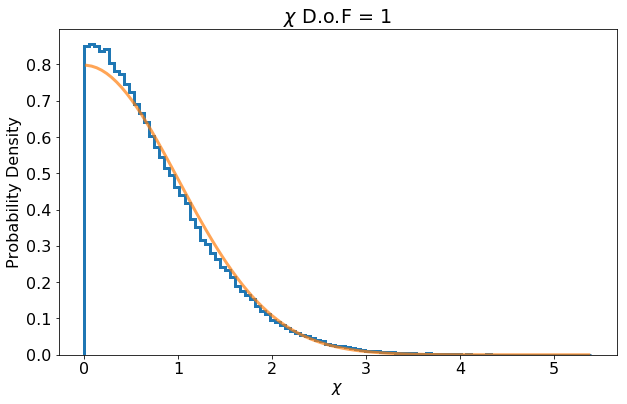

In [12]:
distribution_comparison_plot(
    np.sqrt(chi2_per_dimension).ravel(), 
    distribution=scipy.stats.chi(df=1), 
    hist_kwargs={"bins":101} 
)
plt.title("$\chi$ D.o.F = 1")
plt.ylabel("Probability Density")
plt.xlabel("$\chi$")

We can see that the distribution of PCA coefficients for this data set really is fairly well normally distributed. However the observed distribution of residuals tends to be a little bit closer to 0 than we might naively expected. 

Unfortunately even after converting from $\chi^2$ to $\chi$ it is still not clear from this plot how well the behavior in the high $\chi$ tails matches to the expected theoretical behavior. We can get a much better view of the low probability tails by moving from probability density to log probability density. This will greatly expand the scale of the plot as we move close to 0 emphasizing relative changes at the expense of making absolute changes in probability difficult to gauge.


(0.0001, 1.0)

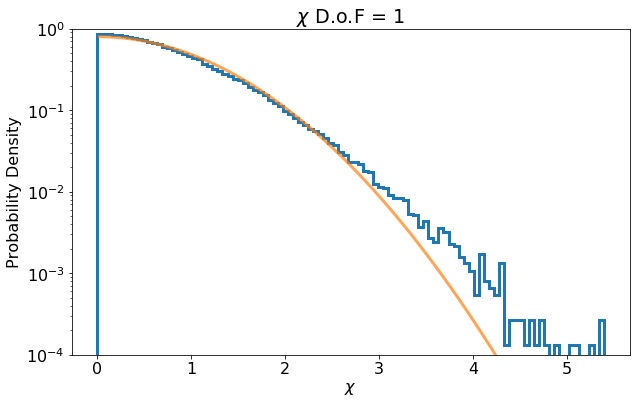

In [13]:
distribution_comparison_plot(
    np.sqrt(chi2_per_dimension).ravel(), 
    distribution=scipy.stats.chi(df=1), 
    hist_kwargs={"bins":101, "log":True} 
)
plt.title("$\chi$ D.o.F = 1")
plt.ylabel("Probability Density")
plt.xlabel("$\chi$")

plt.ylim(1e-4, 1.0)

In the log scale the density variations close to the core of the distribution are squeezed to insignificance (since although they are significant in terms of counts they represent a fairly small fractional difference). At the same time it is clear that the tails of the observed PCA coefficients are heavier than one would expect for truly normally distributed variables. Do those heavy tails represent the presence of outlier images?

How unlikely exactly is a $\chi$ value of above 5? Supposing that the fitted probability distributions are exact a naive calculation gives a lottery winning level of rarity.

In [14]:
1-scipy.stats.chi(df=1).cdf(5.0)

5.7330314373604807e-07

Which might be enough to merit a look at the images showing these high $\chi$ coefficients. Individually rare events still happen in large volumes of data. How many such 5+ events should we expect given that we are looking at such a large number of coefficients?

In [15]:
(1-scipy.stats.chi(df=1).cdf(5.0))*max_components*len(faces)

0.08026244012304673

The fact that we expect on average much less than one such coefficient over the whole data set and that we get several is enough to make a strong claim that the images aren't drawn from exactly the normal distribution that we are using to analyze them but it isn't really cause to think that we have found any anomalies.

Intuitively we know that images of faces aren't really perfectly normally distrirubed and we shouldn't forget that our estimates of the amount of variance in each dimension is based on just 400 observed images and is itself quite uncertain. 
Unless we have reason to think that the form of our probability distribution is exact and its parameters well estimated we ought not take our distribution too seriously. However that is not to say that we can't still use an approximately correct distributional form to detect outliers. After all if one of the $\chi$ coefficients was 50 instead of just 5 that point would be an outlier. 

If all of the coefficients corresponding to $\chi$ values above 4 or 5 come from the same few images we certainly should take notice. Lets find the image with the most anomalous coefficient and take a look at it. We can compare the full distribution of all the coefficients for that image and investigate what the image would look like if we decreased the magnitudes of the outlying coefficient(s) into the more normal range of 2 or 3 sigma.

In [16]:
anom_tup = np.unravel_index(np.argmax(chi2_per_dimension), dims=chi2_per_dimension.shape)
anomalous_image_i, anomalous_coeff_j = anom_tup
anom_tup

(264, 118)

Text(0.5,0,'$\\chi$')

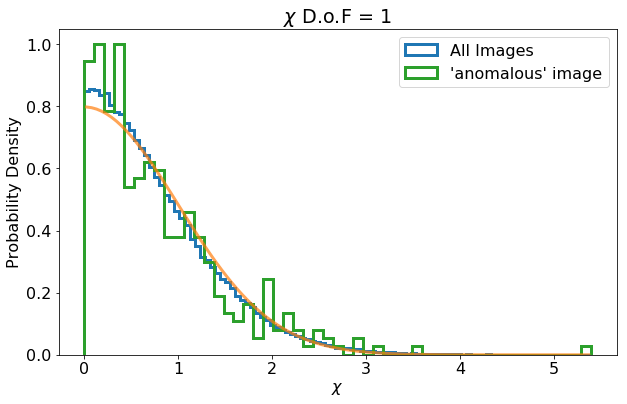

In [17]:
fig, ax = plt.subplots()
distribution_comparison_plot(
    np.sqrt(chi2_per_dimension).ravel(), 
    distribution=scipy.stats.chi(df=1), 
    hist_kwargs={"bins":101, "label":"All Images"},
    ax=ax
)
hres = ax.hist(
    np.sqrt(chi2_per_dimension[anomalous_image_i]), 
    bins=51, 
    normed=True, 
    histtype="step", 
    lw=3,
    label="'anomalous' image"
)
plt.legend()
plt.title("$\chi$ D.o.F = 1")
plt.ylabel("Probability Density")
plt.xlabel("$\chi$")

Comparing the distribution of other coefficients for the same image to the typical distribution of coefficients we can already see that there is probably nothing remarkable about this image since the distribution of other coefficients is quite typical. 

What does this most anomalous image look like and how different does the reconstructed image look if we set the offending coefficient to zero?

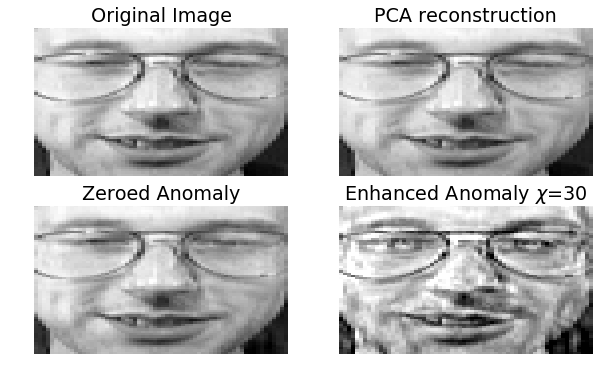

In [18]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

anom_im = faces[anomalous_image_i]
vmin, vmax = np.min(anom_im), np.max(anom_im)

ax = axes[0]
view_as_image(anom_im, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Original Image")

ax = axes[1]
#use the corresponding PCA expansion to reconstruct the face image
cur_coeffs = projected_coeffs[[anomalous_image_i]].copy()
cpca = pca_expansions[fold_indexes[anomalous_image_i]]
full_reconstruction = cpca.inverse_transform(cur_coeffs).squeeze()
view_as_image(full_reconstruction, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("PCA reconstruction")

ax = axes[2]

#zero out the offending coefficient
cur_coeffs[0, anomalous_coeff_j] = 0.0
zeroed_reconstruction = cpca.inverse_transform(cur_coeffs).squeeze()
view_as_image(zeroed_reconstruction, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Zeroed Anomaly")

ax = axes[3]
enhanced_chi = 30
cur_coeffs[0, anomalous_coeff_j] = enhanced_chi*np.sqrt(cpca.explained_variance_[anomalous_coeff_j])
enhanced_anomaly_reconstruction = cpca.inverse_transform(cur_coeffs).squeeze()
view_as_image(enhanced_anomaly_reconstruction, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Enhanced Anomaly $\chi$={}".format(enhanced_chi));

The image its reconstruction, and its reconstruction after zeroing out the potentially anomalous coefficient all look more or less the same. If instead we enhance the anomalous coefficient so that the corresponding $\chi$ score is much larger say $\chi=30$ then the picture looks clearly anomalous.

In this case leaning on our understanding of faces and images we can fairly confidently say that there is nothing really particularly unusual about this image. The type of variation is of a typical sort in the sense that the variation looks one of our principal components it is slightly a-typical in magnitude but probably not enough that we need be concerned. On the other hand if the signal were stronger (say $\sqrt{\chi^2} = \sqrt{400} = \chi = 30$) then even though the character of the variation is of a typical sort the sheer magnitude of that variation would be enough to arouse suspicion.

# $\chi$ distribution for multiple degrees of freedom.

Analyzing the variation in the images one PCA coefficient at a time is a perfectly legitimate strategy to pursue for anomaly detection but it suffers on several accounts. Because we have a potentially large number of coefficients which we are monitoring for anomalies we increase the chances that we will detect an "anomaly" which is really just normal random fluctuation. In addition each coefficient by itself is less strong of a signal than we can get by combining the variations in coefficients together.

Lets take only the first k PCA components and analyze the $\chi^2$ distribution arising from analyzing all those dimensions together. 

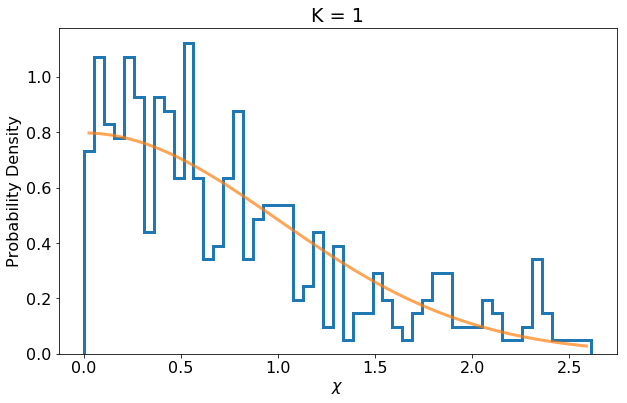

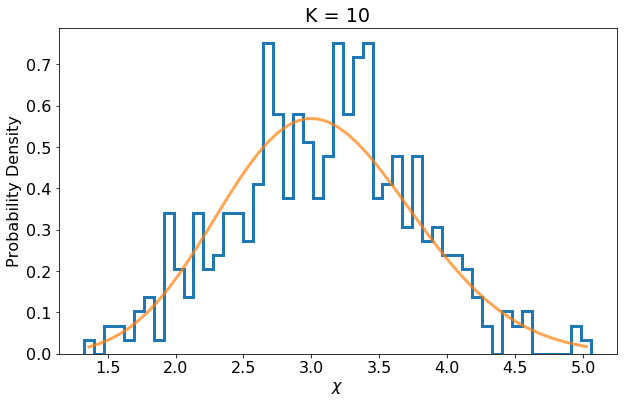

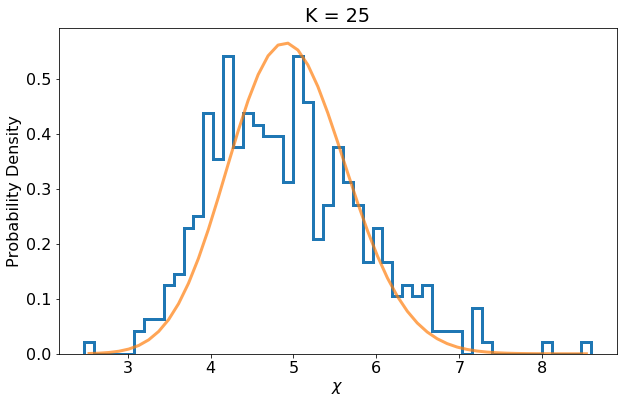

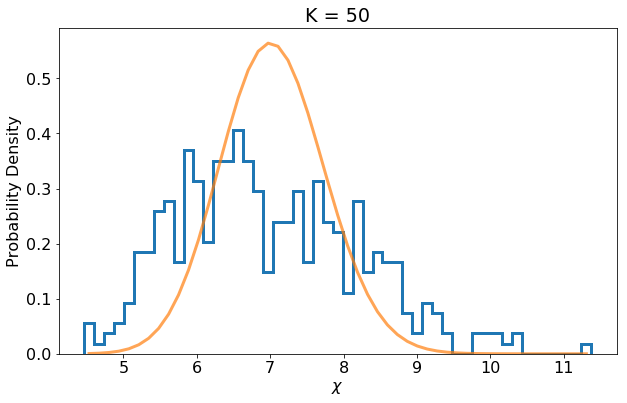

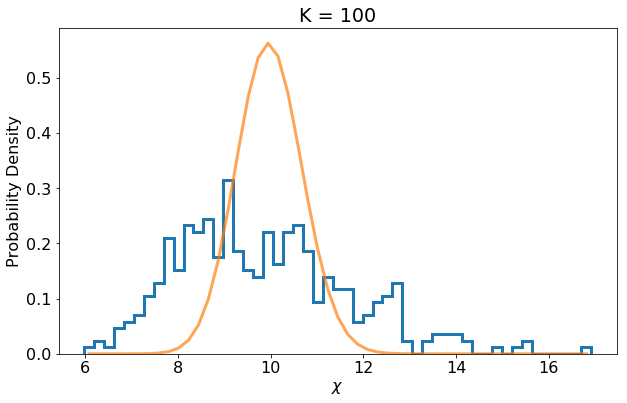

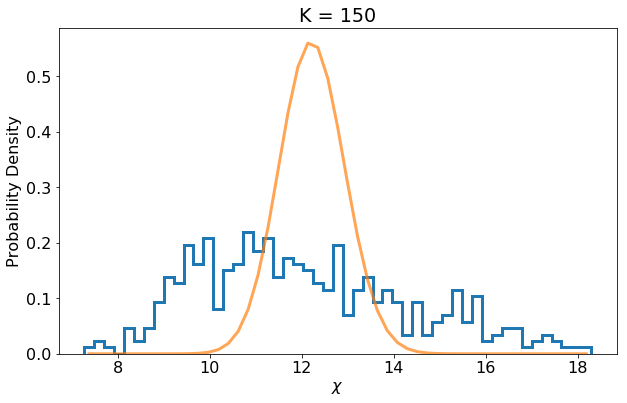

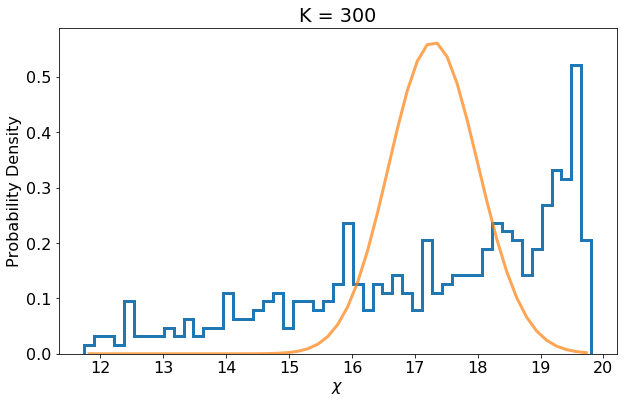

In [19]:
for degrees_of_freedom in [1, 10, 25, 50, 100, 150, 300]:
    fig, ax = plt.subplots()
    
    distribution_comparison_plot(
        np.sqrt(np.sum(chi2_per_dimension[:, :degrees_of_freedom], axis=1)).ravel(), 
        distribution=scipy.stats.chi(df=degrees_of_freedom), 
        hist_kwargs={"bins":51},
        ax=ax
    )
    plt.title("K = {}".format(degrees_of_freedom))
    plt.ylabel("Probability Density")
    plt.xlabel("$\chi$")
    plt.show()

Unlike the situation when we were analyzing the distributions of the individual coefficiets we can now clearly see that as we include more and more dimensions to the analysis that the distribution of $\chi$ values becomes less and less like a theoretical $\chi^2$ distribution.

Since there is no one "true" probability distribution over face images in a meaningful sense there is no "right" answer about why this is happening. But intuitively this sort of behavior makes sense if we suppose that the first few principal components are fiting to real structure within the image data and then eventually turning over to mostly picking up random fluctuations. This is really just a much more sophisticated version of the discussion about empirical noise models way back in part 1 of this blog post series. This is especially clear as the dimension of the PCA expansion starts to butt up against the number of sampled images. Just as you can't really robustly estimate the variance of a 1D variable from just a single sample you can't estimate the covariance of a D dimensional vector value from just D samples. In the multivariate case though we can fairly accurately estimate variance along certain special directions but we start to run out of statistical power as we start to deal with variations in directions which aren't well represented by our dataset.

Acting under that assumption then it seems that the sensible thing to do would be to use only the first 25 or so principal components and their associated variances to gauge how unusual the variations of a given image are. But this means we are using just a 25 dimensional subspace of a 4096 dimensional feature space! What do we do with the other 4071  data dimensions?

## A Subspace Isn't Enough

If we stop short of having a full rank covariance matrix we lose all ability to reason about the variations outside of our chosen k dimensional subspace. To see that this is potentially a foolish idea lets have some fun and design some adversarially modified faces to illustrate how easy it to fool our k dimensional $\chi^2$ statistics.

In [20]:
def random_orthogonal_vector(
    basis, 
    seed_noise = None,
):
    """
    Generates a random vector which is orthogonal to the given basis
    
    The input basis is assumed to be orthonormal.
    """
    if seed_noise is None:
        #generate seed noise
        seed_noise = np.random.normal(size=basis.shape[1])
    
    coeffs = np.dot(basis, seed_noise)
    
    #coeffs_lsq = np.linalg.lstsq(basis.transpose(), seed_noise)[0]
    #assert np.testing.assert_allclose(coeffs, coeffs_lsq)
    
    #project noise onto the given basis
    basis_projection = np.dot(basis.transpose(), coeffs)
        
    #subtract off the component of the noise that lies in the spanned subspace
    resid = seed_noise-basis_projection
    
    #normalize the resulting vector
    resid /= np.sqrt(np.sum(resid**2))
    
    return resid

#make a perturbation vector which is orthogonal to the PCA basis
perturbation = 30*random_orthogonal_vector(
    pca.components_,
    seed_noise = scipy.ndimage.filters.gaussian_filter(
        np.random.normal(size=(64,64),),
        8,
    ).reshape((-1,))
)

#add the orthogona perturbation in to the faces dataset
perturbed_faces = faces+perturbation

In [21]:
#double check that the data coefficients in PCA space don't change
np.mean(np.abs(pca.transform(faces) - pca.transform(perturbed_faces)))

1.1207800033138807e-14

In [22]:
# and that the reconstruction of both the perturbed and unperturbed faces are identical
pca_reconstructions = pca.inverse_transform(pca.transform(faces))
perturbed_reconstructions = pca.inverse_transform(pca.transform(perturbed_faces))

np.mean(np.abs(pca_reconstructions-perturbed_reconstructions))

4.7758220040336825e-15

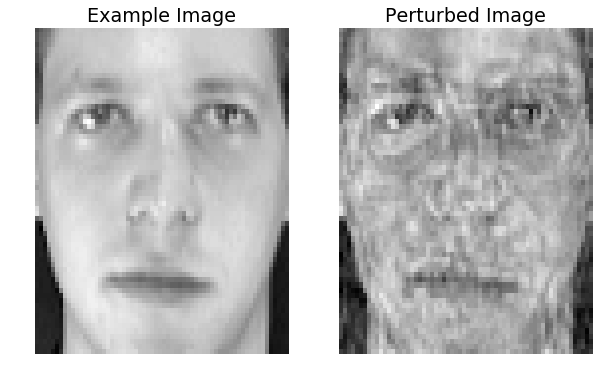

In [23]:
fig, axes = plt.subplots(1, 2)

ax = axes[0]
view_as_image(faces[0], ax=ax)
ax.set_title("Example Image")

ax = axes[1]
view_as_image(perturbed_faces[0], ax=ax)
ax.set_title("Perturbed Image");

I don't think anyone would think that the two images above should be considered nearly identical. But from the perspective of their PCA coefficients they are exactly the same. Clearly simply ignoring the subspace not spanned by the typical variations of our data is not a good strategy for detecting anomalies. How can we alter the $chi^2$ statistic in order to deal with the other 4,000+ dimensions we are leaving out in our PCA expansion?

## Putting it all together

If you squint hard enough you may recognize this as being the problem of the covariance matrix $\Sigma_k$ having determinant 0 coming back to haunt us. The easiest way to regularize a covariance matrix to be positive definite is to simply add an identity matrix to it with some small magnitude. Thus instead of using the covariance matrix $\Sigma_k$ we use the slightly modified covariance matrix $\Sigma_k + \epsilon I$.

If we subtract off the PCA model for a data point keeping K components the results will contain all of the variation in the M-K orthogonal subspace. If we simply sum up the square of these residuals multiplied by some characteristic noise level $\epsilon$ the $\chi^2$ value over the first k dimensions captures the learned structured variation from the $\Sigma_k$ term (call this $\chi_k^2$) and the sum of the residuals left over captures the $\epsilon I$ term (call this $\chi_\epsilon^2$. Thus we can calculate a nice consistent $\chi^2$ value over the fully dimensional space via.

$$
\chi_{full}^2 = \chi_k^2 + \chi_\epsilon^2
$$

The parts of any anomalous variation which lie in the PCA subspace will alter the PCA coefficient magnitudes and the orthogonal part will leave residuals which will be collected in the squared residual sum. Following the logic of the post about empirical noise modeling (see the link at the top of this post). We pick the factor of $\epsilon$ to use to scale the residuals as the inverse of the variance of the last principal component whose value we incorporate into the $\chi_k^2$ value. Lets look at this total $\chi$ distribution and see how it looks. I've picked the 100'th component as the cutoff point for the PCA expansion because the rise in the captured variance curve starts looking very close to linear at around that point (again see the empirical noise model post for details).

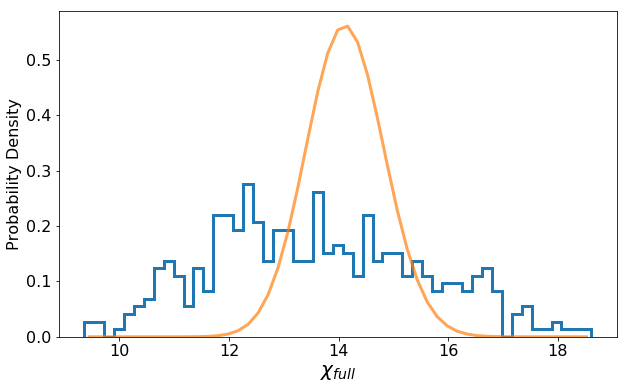

In [98]:
k_cut = 100
pca_partial = sklearn.decomposition.PCA(n_components=k_cut).fit(faces)

projected_coeffs = pca_partial.transform(faces)
chi2_vals = projected_coeffs**2/pca_partial.explained_variance_

chi2_k = np.sum(chi2_vals, axis=1)

pca_reconstructions = pca_partial.inverse_transform(pca_partial.transform(faces))
residuals = faces - pca_reconstructions

eps_scale = pca_partial.explained_variance_[-1]
chi2_eps = np.sum(residuals**2, axis=1)/eps_scale

fig, ax = plt.subplots()
chi2_full = np.sqrt(chi2_k + chi2_eps)
distribution_comparison_plot(
    chi2_full,
    distribution=scipy.stats.chi(df=200),
    hist_kwargs={"bins":51},
    ax=ax
)

plt.ylabel("Probability Density")
plt.xlabel("$\chi_{full}$", fontsize=20);


I chose a total number of degrees of freedom for the whole distribution at 200 because if you plot up the curve for 4096 degrees of freedom like you might expect from the number of pixels in our images or 400 degrees of freedom like you might expect from the total number of samples you just get a flat line close to 0. It is clear from looking at the cumulative variance curves that the effective number of dimensions peters out around dimension 200 and so it isn't much of a surprise that the effective numbers of degrees of freedom is around 200 as well.

From the plot above we can clearly see that the resulting distribution for $\chi_{full}$ isn't consistent with a $\chi$ distribution. The reasons for this are pretty clear when you take a look at the residuals for one of the images at the chosen level of approximation.

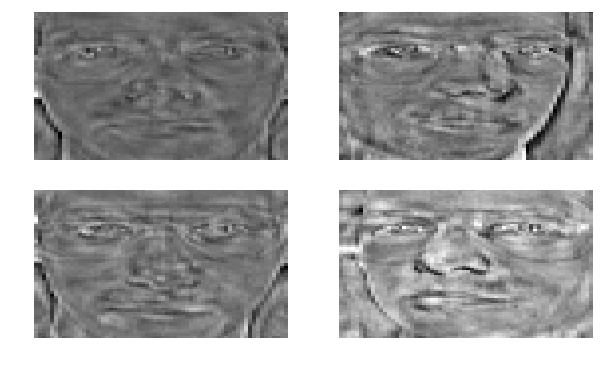

In [101]:
fig, axes  = plt.subplots(2, 2)
axes = axes.ravel()

for i in range(len(axes)):
    view_as_image(residuals[i], ax=axes[i])

We are treating these images as though they were structureless white noise but they clearly retain a huge amount of structure that we can't accurately capture with just a simple linear model. The fact that the first few dozen dimensions look so convincingly normally distributed is really more of a testament to the central limit theorem than to anything else. The fact that the distribution is clearly not a normal distribution as we push out into hundreds of different dimensions isn't telling us that our statistical framework isn't useful. But simply that we shouldn't take the assumption of our distribution of faces being normal distributed too seriously.

This $\chi_{full}$ distribution can't be fooled by shenanigans occuring outside of our k-dimensional PCA subspace but still takes into consideration the typical sorts of variations that we see in our data. 

I hope you enjoyed the tour of PCA as a probabilistic framework. Have fun applying the ideas to your own data!